In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import numpy as np
import os
from PIL import Image
import glob
%matplotlib inline

In [31]:
MAP_NAME = "Spa_map"

In [32]:
csv_files = glob.glob(f'inputs/tracks/{MAP_NAME}.csv', recursive=True)
csv_files = sorted(csv_files)
csv_files

['inputs/tracks/Spa_map.csv']

In [33]:
raw_data = pd.read_csv(csv_files[-1], header=None, sep=',')
raw_data

,0,1,2,3
0,# x_m,y_m,w_tr_right_m,w_tr_left_m
1,10.6506,-65.7844,1.0361,1.0361
2,10.6506,-65.6917,1.0361,1.0361
3,10.6506,-65.5990,0.9981,0.9981
4,10.7433,-65.5064,1.0361,1.0361
...,...,...,...,...
5292,10.4652,-66.2477,1.0361,1.0361
5293,10.4652,-66.1551,1.0361,1.0361
5294,10.4652,-66.0624,0.9981,0.9981
5295,10.5579,-65.9697,1.0361,1.0361


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

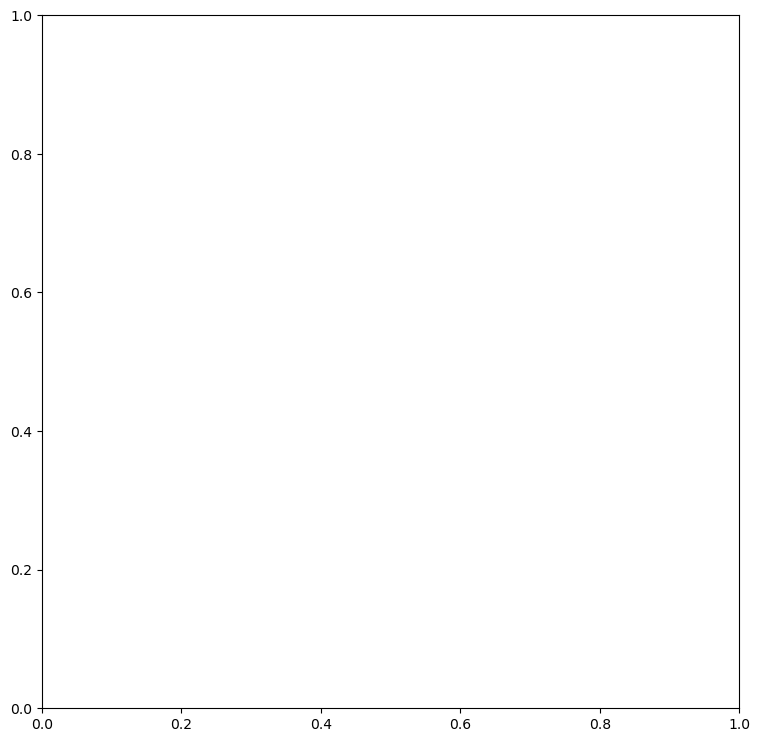

In [34]:
plt.figure(figsize=(9,9))
plt.plot(raw_data.iloc[:, 0], raw_data.iloc[:, 1])

In [35]:
# Overlay the racetrack on the map
# load map yaml
if os.path.exists(f"maps/{MAP_NAME}.png"):
    map_img_path = f"maps/{MAP_NAME}.png"
elif os.path.exists(f"maps/{MAP_NAME}.pgm"):
    map_img_path = f"maps/{MAP_NAME}.pgm"
else:
    raise Exception("Map not found!")

map_yaml_path = f"maps/{MAP_NAME}.yaml"
with open(map_yaml_path, 'r') as yaml_stream:
    try:
        map_metadata = yaml.safe_load(yaml_stream)
        map_resolution = map_metadata['resolution']
        origin = map_metadata['origin']
    except yaml.YAMLError as ex:
        print(ex)

# calculate map parameters
orig_x = origin[0]
orig_y = origin[1]
# ??? Should be 0
orig_s = np.sin(origin[2])
orig_c = np.cos(origin[2])

# get the distance transform
transformed_data = raw_data.copy()
transformed_data -= np.array([orig_x, orig_y, 0])
transformed_data.iloc[:, :2] /= map_resolution

raw_map_img = np.array(Image.open(map_img_path).transpose(Image.FLIP_TOP_BOTTOM))
raw_map_img = raw_map_img.astype(np.float64)


ValueError: Unable to coerce to Series, length must be 4: given 3

In [29]:
plt.figure(figsize=(15,15))
plt.imshow(raw_map_img, cmap='gray', origin='lower')
plt.plot(transformed_data.iloc[:, 0], transformed_data.iloc[:, 1], color='red')
# Save image without the axis
plt.axis('off')
plt.savefig(f"outputs/{MAP_NAME}_raceline.png", bbox_inches='tight', pad_inches=0)

NameError: name 'raw_map_img' is not defined

<Figure size 1500x1500 with 0 Axes>

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,15))
plt.scatter(transformed_data.iloc[:, 0], transformed_data.iloc[:, 1], c=transformed_data.iloc[:, 2])
cbar = plt.colorbar(shrink=0.5)
cbar.set_label('velocity (m/s)')

plt.imshow(raw_map_img, cmap='gray', origin='lower')
plt.axis('off')

## (OPTIONAL) Overlay on the original map

In [21]:
ORIG_MAP = f"{MAP_NAME}_RAW"
orig_map_img = np.array(Image.open(f"maps/{ORIG_MAP}.pgm").transpose(Image.FLIP_TOP_BOTTOM))
orig_map_img = orig_map_img.astype(np.float64)
plt.figure(figsize=(15,15))
plt.imshow(orig_map_img, cmap='gray', origin='lower')
plt.plot(transformed_data.iloc[:, 0], transformed_data.iloc[:, 1], color='red')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jejeb\\source\\repos\\Raceline-Optimization-up\\maps\\Montreal_map_RAW.pgm'

In [22]:
plt.figure(figsize=(15,15))
plt.imshow(orig_map_img, cmap='gray', origin='lower')
plt.scatter(transformed_data.iloc[:, 0], transformed_data.iloc[:, 1], c=transformed_data.iloc[:, 2])
cbar = plt.colorbar(shrink=0.5)
cbar.set_label('velocity (m/s)')

NameError: name 'orig_map_img' is not defined

<Figure size 1500x1500 with 0 Axes>

## Visualize Velocity Profile in 3D

In [ ]:
raw_data_np = transformed_data.to_numpy()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt
# Visualize Velocity Profile
scale_x = 1.0
scale_y = 1.0
scale_z = 0.3  # scale z axis such that it does not appear stretched

# create 3d plot

fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')

# recast get_proj function to use scaling factors for the axes
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([scale_x, scale_y, scale_z, 1.0]))

ax.grid()
ax.set_aspect("auto")
ax.set_xlabel("east in m")
ax.set_ylabel("north in m")

# Doesn't work
# import matplotlib
# x,y = np.mgrid[0:orig_map_img.shape[0], 0:orig_map_img.shape[1]]
# ax.plot_surface(x,y,np.sin(0*x), facecolors=matplotlib.cm.ScalarMappable(cmap='gray').to_rgba(orig_map_img))

# plot velocity profile in 3D
ax.plot(raw_data_np[:, 0], raw_data_np[:, 1], raw_data_np[:, 2], color="k")
ax.set_zlabel("velocity in m/s")

# plot vertical lines visualizing acceleration and deceleration zones
ind_stepsize = 1
cur_ind = 0
no_points_traj_vdc = np.shape(raw_data_np)[0]
prev_vel = 0
curr_vel = 0

while cur_ind < no_points_traj_vdc - 1:
	curr_vel = raw_data_np[cur_ind, 2]
	x_tmp = [raw_data_np[cur_ind, 0], raw_data_np[cur_ind, 0]]
	y_tmp = [raw_data_np[cur_ind, 1], raw_data_np[cur_ind, 1]]
	z_tmp = [0.0, curr_vel]  # plot line with height depending on velocity

	# get proper color for line depending on acceleration
	if curr_vel - prev_vel > 0.0:
		col = "g"
	elif curr_vel - prev_vel < 0.0:
		col = "r"
	else:
		col = "gray"
	
	prev_vel = curr_vel

	# plot line
	ax.plot(x_tmp, y_tmp, z_tmp, color=col)

	# increment index
	cur_ind += ind_stepsize


plt.show()

/tmp/ipykernel_2295346/3404177215.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
